Episode: 100, Reward: -49537.76095581055, Robot Arm Angle: [24.406439]
Episode: 200, Reward: -27826.32704925537, Robot Arm Angle: [96.2404]
Episode: 300, Reward: 994.2051391601562, Robot Arm Angle: [174.20514]
Episode: 400, Reward: -10765.101806640625, Robot Arm Angle: [153.87166]
Episode: 500, Reward: 997.0436859130859, Robot Arm Angle: [177.04369]
Episode: 600, Reward: 865.7750549316406, Robot Arm Angle: [170.03592]
Episode: 700, Reward: -21862.461715698242, Robot Arm Angle: [261.37308]
Episode: 800, Reward: -14130.124481201172, Robot Arm Angle: [235.97246]
Episode: 900, Reward: -23236.714401245117, Robot Arm Angle: [267.2379]
Episode: 1000, Reward: -39349.05294799805, Robot Arm Angle: [320.08392]
Episode: 1100, Reward: -36470.30485534668, Robot Arm Angle: [67.25958]
Episode: 1200, Reward: -53964.71159362793, Robot Arm Angle: [0.1433967]
Episode: 1300, Reward: -31889.478881835938, Robot Arm Angle: [295.1814]
Episode: 1400, Reward: -47031.975341796875, Robot Arm Angle: [346.23688]
Epi

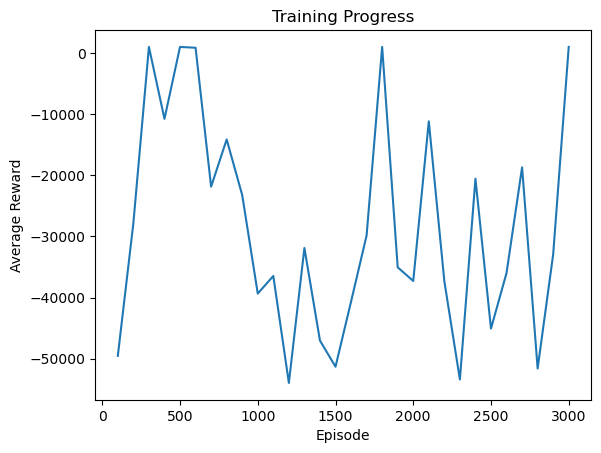

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# 로봇 팔을 모델링한 클래스
class RobotArmModel:
    def __init__(self):
        # 초기 각도를 랜덤으로 설정 (0도부터 360도 사이)
        self.angle = np.random.uniform(0, 360)

    def move(self, action):
        # 주어진 행동을 사용하여 로봇 팔의 각도 업데이트
        self.angle += action
        self.angle = self.angle % 360
        return self.angle

# Actor 네트워크 클래스
class ActorNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 추가
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.dropout(x)  # 드롭아웃 적용
        x = torch.tanh(self.fc2(x))
        return x

# Critic 네트워크 클래스
class CriticNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(CriticNet, self).__init__()
        self.fc_state = nn.Linear(state_dim, 128)
        self.fc_action = nn.Linear(action_dim, 128)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, state, action):
        x_state = F.relu(self.fc_state(state))
        x_action = F.relu(self.fc_action(action))
        x = torch.cat((x_state, x_action), dim=1)
        x = F.relu(self.fc2(x))
        return x

# Replay 메모리 클래스
class Memory:
    def __init__(self, capacity):
        self.memory = []
        self.capacity = capacity
        self.data_pointer = 0

    def update(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
        else:
            self.memory[self.data_pointer] = transition
        self.data_pointer = (self.data_pointer + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.memory) < batch_size:
            return []
        return np.random.choice(self.memory, batch_size, replace=False)

# Transition 클래스 정의
class Transition:
    def __init__(self, state=None, action=None, reward=None, next_state=None, done=None):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.done = done

# DDPG 에이전트 클래스
class DDPGAgent:
    def __init__(self, state_dim, action_dim, noise_std=0.1):
        # Actor, Critic 네트워크 및 타겟 네트워크 초기화
        self.actor_net = ActorNet(state_dim, action_dim)
        self.critic_net = CriticNet(state_dim, action_dim)
        self.target_actor_net = ActorNet(state_dim, action_dim)
        self.target_critic_net = CriticNet(state_dim, action_dim)

        # Actor, Critic의 옵티마이저 초기화
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=1e-3)
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), lr=1e-3)

        # Replay 메모리 초기화
        self.memory = Memory(70000)  # 메모리 크기

        # 타겟 네트워크 업데이트 주기
        self.target_update_freq = 100  # 업데이트 주기
        self.target_update_counter = 0

        # Polyak Averaging을 위한 tau 값 추가
        self.tau = 0.005
        
        # 액션 스케일 조정
        self.action_scale = 0.1
        
        # 노이즈 설정
        self.noise_std = noise_std

    def select_action(self, state):
        # 주어진 상태에서 액션 선택
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            action = self.actor_net(state).numpy().flatten()
        # 액션에 노이즈 추가
        action += np.random.normal(0, self.noise_std, action.shape)
        action *= self.action_scale  # 액션 스케일링 추가
        return action

    def train(self, state, action, reward, next_state, done):
        transitions = self.memory.sample(256)
        if not transitions:
            return  # 메모리에서 샘플이 부족하면 학습을 진행하지 않음

        batch = Transition(*zip(*transitions))

        # Critic 네트워크 업데이트 시 보상 스케일링
        scale_factor = 5.0
        reward /= scale_factor  # 보상 스케일링

        # 최종 각도에 도달했을 때 추가적인 보상
        done_reward = 1000.0  # 보상 설정
        done_reward *= np.abs(self.robot_arm.angle - 180.0) < 10.0  # 종료 조건

        # 최종 각도에 따른 리워드 및 종료 조건 설정
        reward = -np.abs(self.robot_arm.angle - 180.0) + done_reward

        # 타겟 Q 값 계산
        with torch.no_grad():
            target_actions = self.target_actor_net(batch.next_state)
            target_q_values = self.target_critic_net(batch.next_state, target_actions).squeeze()
            target_q_values = target_q_values * (1 - batch.done)
            target_q_values += batch.reward

        # Critic 네트워크 업데이트
        critic_loss = F.mse_loss(self.critic_net(batch.state, batch.action).squeeze(), target_q_values)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor 네트워크 업데이트
        actor_loss = -self.critic_net(batch.state, self.actor_net(batch.state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 타겟 네트워크 주기적 업데이트
        if self.target_update_counter % self.target_update_freq == 0:
            # Polyak Averaging을 통한 부드러운 업데이트
            for target_param, param in zip(self.target_critic_net.parameters(), self.critic_net.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

        self.target_update_counter += 1

    def save_model(self, actor_path, critic_path):
        # 저장할 때 인코딩 문제를 우회하기 위해 _use_new_zipfile_serialization 및 pickle_protocol 사용
        torch.save({
            'actor_state_dict': self.actor_net.state_dict(),
            'actor_optimizer_state_dict': self.actor_optimizer.state_dict(),
            'critic_state_dict': self.critic_net.state_dict(),
            'critic_optimizer_state_dict': self.critic_optimizer.state_dict(),
            'memory': self.memory.memory,
            'target_update_counter': self.target_update_counter
        }, actor_path, _use_new_zipfile_serialization=False, pickle_protocol=5)
        
        torch.save({
            'target_actor_state_dict': self.target_actor_net.state_dict(),
            'target_critic_state_dict': self.target_critic_net.state_dict(),
        }, critic_path, _use_new_zipfile_serialization=False, pickle_protocol=5)

    def load_model(self, actor_path, critic_path):
        # 불러올 때도 동일한 옵션 사용
        checkpoint_actor = torch.load(actor_path, map_location=torch.device('cpu'), _use_new_zipfile_serialization=False, pickle_protocol=5)
        checkpoint_critic = torch.load(critic_path, map_location=torch.device('cpu'), _use_new_zipfile_serialization=False, pickle_protocol=5)

        self.actor_net.load_state_dict(checkpoint_actor['actor_state_dict'])
        self.actor_optimizer.load_state_dict(checkpoint_actor['actor_optimizer_state_dict'])
        
        self.critic_net.load_state_dict(checkpoint_critic['critic_state_dict'])
        self.critic_optimizer.load_state_dict(checkpoint_critic['critic_optimizer_state_dict'])
        
        self.memory.memory = checkpoint_actor['memory']
        self.target_update_counter = checkpoint_actor['target_update_counter']
        
        self.target_actor_net.load_state_dict(checkpoint_critic['target_actor_state_dict'])
        self.target_critic_net.load_state_dict(checkpoint_critic['target_critic_state_dict'])
        
        
# Main 클래스
class Main:
    def __init__(self):
        # 환경 초기화
        self.robot_arm = RobotArmModel()
        self.state_dim = 1  # 로봇 팔 각도 디멘젼
        self.action_dim = 1  # 각도의 변화량 디멘젼
        self.best_reward = float('-inf')  # 최고 성능을 저장할 변수

        # DDPG 에이전트 초기화
        self.agent = DDPGAgent(self.state_dim, self.action_dim, noise_std = 0.1)

        # 학습 루프
        self.episode_rewards = []

    def run_and_save_model(self):
        for episode in range(3000):
            # 초기 각도를 랜덤으로 설정
            self.robot_arm = RobotArmModel()
            state = np.array([self.robot_arm.angle])
            episode_reward = 0

            for _ in range(300):
                action = self.agent.select_action(state)
                next_state = np.array([self.robot_arm.move(action)])

                done_reward = 1000.0
                done_reward *= np.abs(self.robot_arm.angle - 180.0) < 10.0
                reward = -np.abs(self.robot_arm.angle - 180.0) + done_reward

                episode_reward += reward

                self.agent.train(state, action, reward, next_state, False)

                state = next_state

                if done_reward > 0:
                    break

            current_reward = episode_reward.mean()

            if current_reward > self.best_reward:
                self.best_reward = current_reward
                self.agent.save_model("best_actor_model.pth", "best_critic_model.pth")

            if (episode + 1) % 100 == 0:
                self.episode_rewards.append(current_reward)
                print(f"Episode: {episode + 1}, Reward: {current_reward}, Robot Arm Angle: {self.robot_arm.angle}")

        print(f"Final Robot Arm Angle: {self.robot_arm.angle}")
        plt.plot(np.arange(100, 3001, 100), self.episode_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.title('Training Progress')
        plt.show()

    def save_and_load_model_example(self):
        self.agent.save_model("best_actor_model.pth", "best_critic_model.pth")
        self.agent.load_model("best_actor_model.pth", "best_critic_model.pth")
        self.test()

# 실행 및 모델 저장
if __name__ == "__main__":
    main_instance = Main()
    main_instance.run_and_save_model()